<a href="https://colab.research.google.com/github/rodriguezhh/IA_SIDIEN/blob/main/Inteligencia_Artificial_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIAGNÓSTICO DE ENFERMEDADES EN LA HOJA DEL TOMATE MEDIANTE UN SISTEMA EMBEBIDO USANDO INTELIGENCIA ARTIFICIAL E IMÁGENES.
## Trabajo De Grado

## **Acceder al drive**

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


##**Importación de librerías**

In [2]:
#librerias para el modelo
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np 
from keras.applications.vgg19 import VGG19

# librerias para el dataset
from keras.preprocessing.image import ImageDataGenerator

#librerias para las métricas 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Base De Datos**
La base de datos consta de tres enfermedades de la hoja de la planta del tomate y la hoja sana de la misma. La información, en este caso las imágenes, tiene una dimensión de 256 x 256 píxeles.

Guardamos la información previamente separada en la variables train, validation y test.

In [3]:
# Definimos el tamaño de las imágenes y el tamaño del lote
image_size = 224 
batch_size = 32

# Creamos un generador de datos de imágenes para el entrenamiento con el objeto ImageDataGenerator
train_generator = ImageDataGenerator()

# Cargamos las imágenes de entrenamiento desde el directorio especificado y las transformamos utilizando el generador de datos
train = train_generator.flow_from_directory(
    '/content/drive/MyDrive/TESIS/Dataset/60_20/train', # Ruta al directorio de entrenamiento
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    batch_size = batch_size, # Definimos el tamaño del lote
    shuffle = True, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Cargamos las imágenes de validación desde el directorio especificado y las transformamos utilizando el generador de datos
validation = train_generator.flow_from_directory( 
    '/content/drive/MyDrive/TESIS/Dataset/60_20/val', # Ruta al directorio de validación
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Creamos otro generador de datos de imágenes para las imágenes de prueba
test_generator = ImageDataGenerator()

# Cargamos las imágenes de prueba desde el directorio especificado y las transformamos utilizando el generador de datos
test = test_generator.flow_from_directory(
    '/content/drive/MyDrive/TESIS/Dataset/60_20/test', # Ruta al directorio de prueba
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode='categorical' # Definimos el modo de clasificación categórica
)


Found 7398 images belonging to 4 classes.
Found 1224 images belonging to 4 classes.
Found 1232 images belonging to 4 classes.


Las etiquetas de las imagenes son las siguietes:

In [4]:
train.class_indices

{'Tomato_Early_blight': 0,
 'Tomato_Late_blight': 1,
 'Tomato_healthy': 2,
 'Tomato_mosaic_virus': 3}

## **Modelo**

In [5]:
# Definir la cantidad de canales de la imagen
rgb = 3

# Crear un modelo utilizando la arquitectura ResNet50 pre-entrenada en ImageNet
model_vgg19 = VGG19(
    weights="imagenet",  # Usar los pesos pre-entrenados en ImageNet
    include_top=False,  # No incluir la capa fully-connected de ImageNet
    input_shape=(image_size, image_size, rgb)  # Definir el tamaño de las imágenes de entrada
)

80134624/80134624 [==============================] - 3s 0us/step


Model: "modelo_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

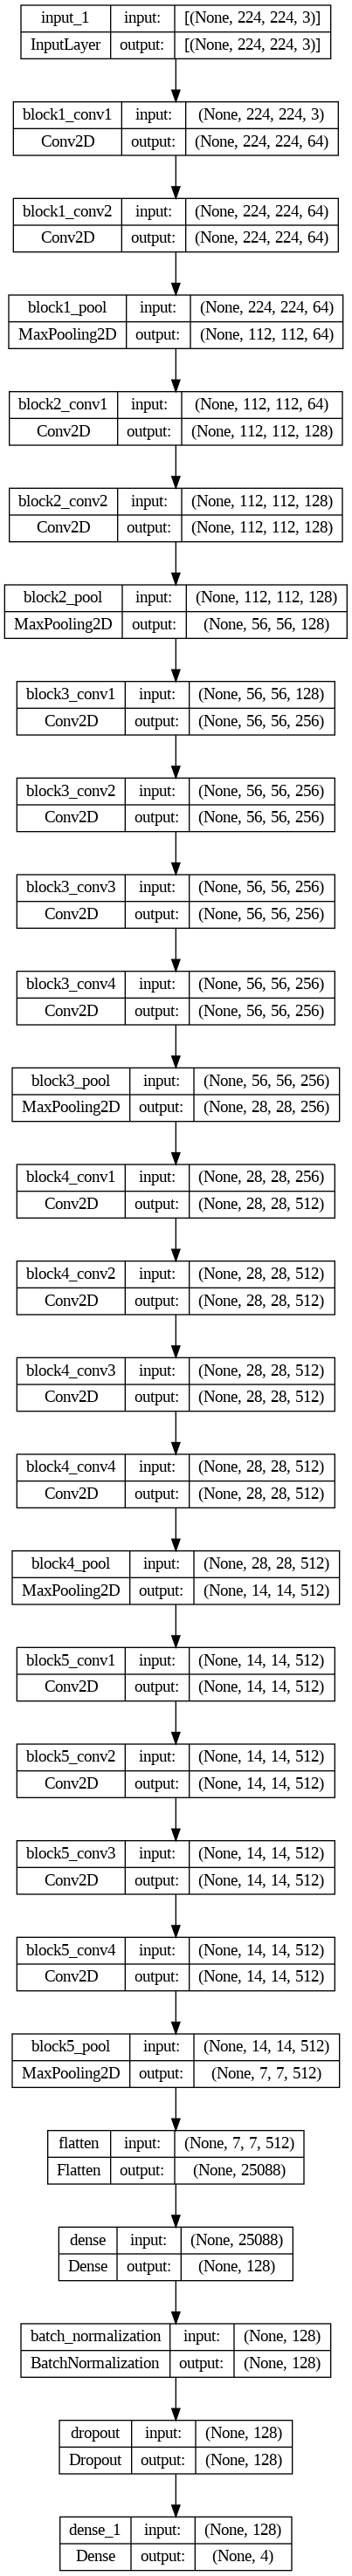

In [6]:
# Asignar la salida de la última capa del modelo VGG19
x = model_vgg19.output

# Capa de aplanamiento
x = layers.Flatten()(x)

# Capa densa
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)

# Capa de Dropout con 20% de probabilidad 
x = layers.Dropout(0.2)(x)

# Capa de salida con activación softmax
outputs = layers.Dense(4, activation="softmax", kernel_initializer='glorot_uniform')(x)

# Crear el modelo
model = keras.Model(inputs=model_vgg19.input, outputs=outputs, name="modelo_VGG19")

# Establecer todas las capas del modelo como no entrenables, excepto las últimas tres capas
for layer in model.layers[:-5]:
	layer.trainable = False

# Resumen del modelo
model.summary()

# Grafica la estructura del modelo
keras.utils.plot_model(model, "modelo_VGG19.png", show_shapes=True)

## **Método Compile de Keras**
Definiendo el optimizador, la función de perdida y la métrica.

1.   Optimizadior: Adam. 
2.   Función de perdida: categorical_crossentropy. Porque previamente se definieron las etiquetas como "one-hot".
3.   Métrica: Accuracy. Se escoge la exactitud porque es la varible estandar de interes de un modelo. 



In [7]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
 loss= keras.losses.CategoricalCrossentropy(),
 metrics=["accuracy"])

## **Callbacks**


1.   EarlyStopping: Nos permite detener el entrenamiento cuando la variable que se monitorea deja de mejorar. 
2.   ReduceLROnPlateau: Reduce el "learning rate" cuando la variable que se monitorea deja de mejorar. 



In [8]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # La métrica que se va a monitorear para detener el entrenamiento
    patience=5,                    # El número de épocas que esperará antes de detener el entrenamiento
    verbose=1,                     # El nivel de detalle que se mostrará durante el entrenamiento
    restore_best_weights=True      # Si se deben restaurar los pesos del modelo a la mejor época durante el entrenamiento
)

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # La métrica que se va a monitorear para reducir la tasa de aprendizaje
    factor=0.2,                   # Factor de reducción de la tasa de aprendizaje
    patience=2,                   # El número de épocas que esperará antes de reducir la tasa de aprendizaje
    verbose=1                     # El nivel de detalle que se mostrará durante el entrenamiento
)

## **Entrenamiento del modelo**

In [10]:
history = model.fit(
    train,
    batch_size = batch_size,
    validation_data = validation, 
    epochs = 9000000,
    callbacks = [earlystopping, reduce_lr],
    )

Epoch 1/9000000
232/232 [==============================] - 4095s 18s/step - loss: 0.4450 - accuracy: 0.8405 - val_loss: 0.2456 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 2/9000000
232/232 [==============================] - 49s 210ms/step - loss: 0.1266 - accuracy: 0.9576 - val_loss: 0.3072 - val_accuracy: 0.9011 - lr: 0.0010
Epoch 3/9000000
232/232 [==============================] - 44s 189ms/step - loss: 0.0570 - accuracy: 0.9831 - val_loss: 0.2401 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 4/9000000
232/232 [==============================] - 44s 189ms/step - loss: 0.0298 - accuracy: 0.9923 - val_loss: 0.2729 - val_accuracy: 0.9216 - lr: 0.0010
Epoch 5/9000000
232/232 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9965
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
232/232 [==============================] - 44s 188ms/step - loss: 0.0170 - accuracy: 0.9965 - val_loss: 0.2891 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 6/9000000
232/232

## **Evaluando el modelo**

In [11]:
scores = model.evaluate(test)
print(scores)

39/39 [==============================] - 552s 15s/step - loss: 0.2453 - accuracy: 0.9261
[0.24533869326114655, 0.9261363744735718]


## **Gráficas de 'Accuracy' y 'Loss' del modelo**

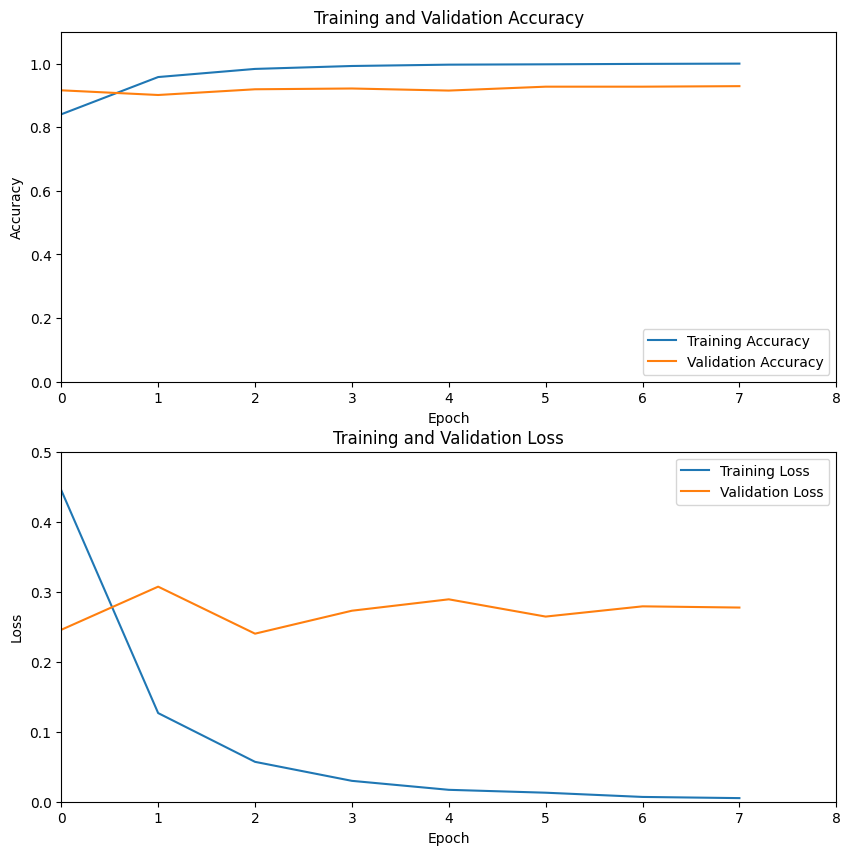

In [16]:
# Se crea una figura con dos imagenes
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

# Se grafica la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlim([0, 8])  # Establecer los límites del eje x
plt.ylim([0, 1.1])  # Establecer los límites del eje y

# Se crea la segunda imagen
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlim([0, 8])  # Establecer los límites del eje x
plt.ylim([0, 0.5])  # Establecer los límites del eje y


# Se muestran los gráficos
plt.show()

## **Matriz de confusión**

39/39 [==============================] - 7s 183ms/step


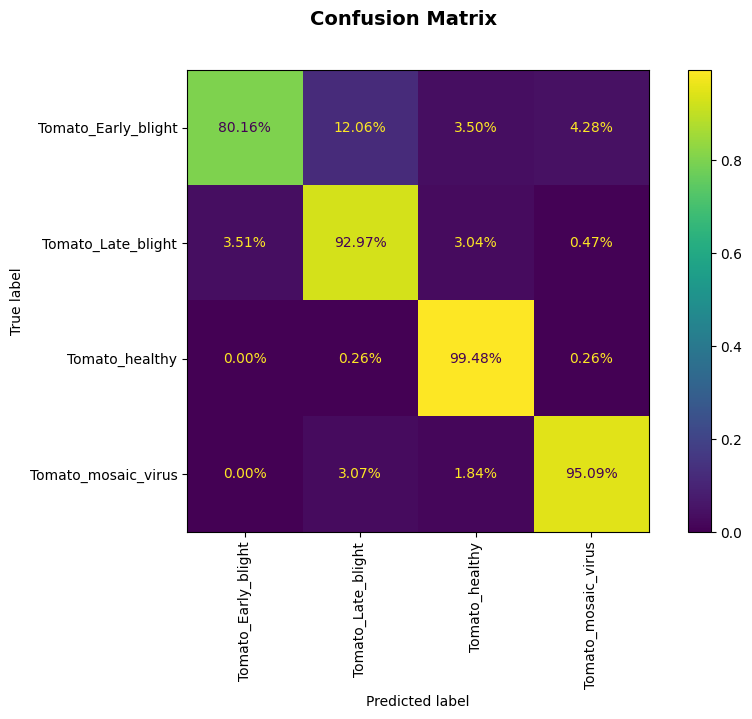

In [13]:
# Generar predicciones en el conjunto de prueba
predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas y las etiquetas de las clases
true_classes = test.classes
class_labels = list(test.class_indices.keys())    

# Calcular la matriz de confusión normalizada
cm = confusion_matrix(
    y_true=true_classes,
    y_pred=predicted_classes,
    normalize='true')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical", values_format=".2%")

# Configurar el título del gráfico
fig.suptitle("Confusion Matrix", fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()

## **Métricas**

In [14]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                     precision    recall  f1-score   support

Tomato_Early_blight       0.93      0.80      0.86       257
 Tomato_Late_blight       0.91      0.93      0.92       427
     Tomato_healthy       0.94      0.99      0.97       385
Tomato_mosaic_virus       0.92      0.95      0.93       163

           accuracy                           0.93      1232
          macro avg       0.93      0.92      0.92      1232
       weighted avg       0.93      0.93      0.92      1232



## **Guardando el modelo**

In [15]:
model.save('modelo_VGG19.h5')